[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [2]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

from dotenv import load_dotenv

load_dotenv(dotenv_path="../../../.env")

True

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

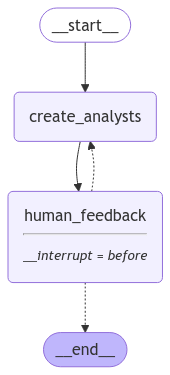

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, emphasizing its modularity and scalability for AI applications. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph as an agent framework. He is concerned with issues of transparency, accountability, and the potential biases that may arise from its implementation in decision-making processes.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Strategist
Description: Ms. Thompson analyzes the business benefits of adopting LangGraph, focusing on cost-effectiveness, compet

In [7]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0815-ff30-6b7d-8002-1f056e922fa5'}}

In [9]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, emphasizing its modularity and scalability for AI applications. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph as an agent framework. He is concerned with issues of transparency, accountability, and the potential biases that may arise from its implementation in decision-making processes.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Strategist
Description: Ms. Thompson analyzes the business benefits of adopting LangGraph, focusing on cost-effectiveness, compet

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0818-c627-6fbb-8005-c4c806f5af73'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Jordan Lee
Affiliation: Tech Startup Incubator
Role: Startup Founder
Description: Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline development processes and enhance product offerings, particularly in terms of scalability and integration with existing systems.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: AI Research Institute
Role: AI Researcher
Description: Dr. Chen is a researcher specializing in AI frameworks and their applications. She is focused on the theoretical benefits of LangGraph, including its efficiency in handling complex data structures and its potential to improve machine learning workflows.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Enterprise Software Company
Role: Product Manager
Description: Michael is a product manager at a leading enterprise software company. He is concerned with the practical implications of 

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [16]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [19]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [21]:
# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("TAVILY_API_KEY")

In [22]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [23]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

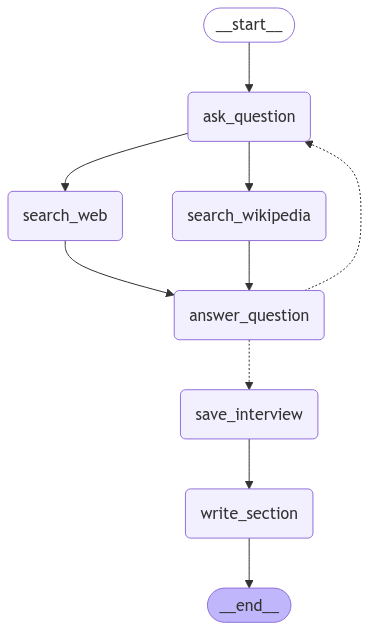

In [24]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [25]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Startup Incubator', name='Jordan Lee', role='Startup Founder', description='Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline development processes and enhance product offerings, particularly in terms of scalability and integration with existing systems.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [26]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Enhancing AI Development with LangGraph: A Game Changer for Startups

### Summary
As the demand for efficient and intelligent solutions in the tech industry grows, startups like Jordan's are increasingly turning to advanced frameworks to streamline their development processes. LangGraph, a powerful AI agent framework, stands out as a transformative tool that not only enhances product offerings but also significantly improves scalability and integration with existing systems. 

LangGraph addresses common challenges faced by AI applications, particularly in maintaining state, memory, and context, which are crucial for delivering high-quality outputs. Unlike traditional frameworks, LangGraph simplifies the creation and management of AI agents, making it uniquely suited for building reliable and fault-tolerant systems. Its innovative features, such as agentic coordination through cyclic graphs, allow for dynamic control flows and iterative processing, enabling agents to interact in loops where outputs can be fed back into the system. This capability is particularly beneficial for startups looking to develop complex workflows that require real-time adaptability and decision-making [1][2][3].

Moreover, LangGraph's architecture is designed to integrate seamlessly with various tools and APIs, allowing developers to create sophisticated AI systems that replicate human-like reasoning. For instance, it can be employed to build decision-making systems that leverage multiple data sources and tools, enhancing the overall functionality of applications [4][5]. The framework's nodes, defined as Python functions, can perform a variety of tasks, from integrating with large language models to processing information and invoking external APIs, thus providing ultimate control over the AI agent's operations [6][7].

The insights gathered from recent discussions highlight that LangGraph not only meets the current needs of AI development but also anticipates future demands for scalability and integration. This positions it as a vital asset for startups aiming to innovate and stay competitive in a rapidly evolving market. The adaptability of LangGraph in diverse projects showcases its potential to revolutionize how AI agents are built and managed, making it an essential consideration for any tech startup focused on AI solutions.

### Sources
[1] https://www.solulab.com/build-ai-agents-with-langgraph/  
[2] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/  
[3] https://datasciencedojo.com/newsletter/agentic-ai-langgraph/  
[4] https://www.cohorte.co/blog/mastering-langgraph-a-step-by-step-guide-to-building-intelligent-ai-agents-with-tool-integration/  
[5] https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4/  
[6] https://www.gettingstarted.ai/langgraph-tutorial-with-example/  
[7] https://www.cohorte.co/blog/mastering-langgraph-a-step-by-step-guide-to-building-intelligent-ai-agents-with-tool-integration/  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [27]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

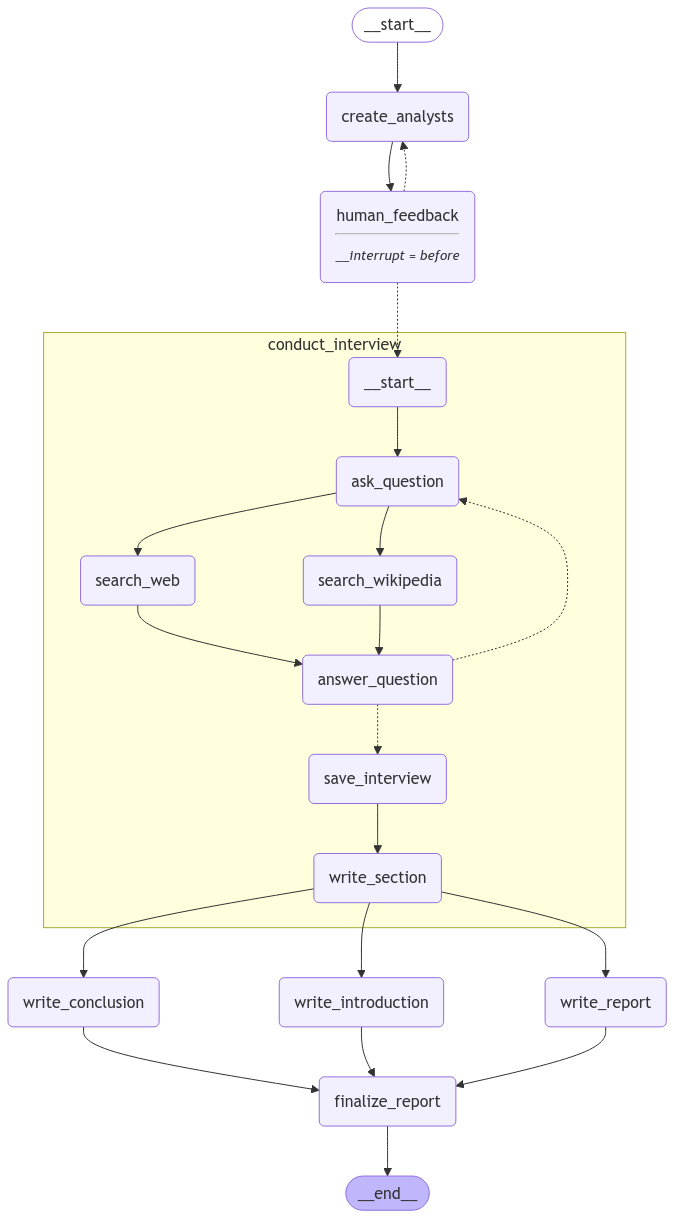

In [28]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [29]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, emphasizing its modularity and scalability for AI applications. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph as an agent framework. He is concerned with issues of transparency, accountability, and the potential biases that may arise from its implementation in decision-making processes.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Strategist
Description: Ms. Thompson analyzes the business benefits of adopting LangGraph, focusing on cost-effectiveness, compet

In [30]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0838-c88b-68af-8002-f9c586b77cee'}}

In [31]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, emphasizing its modularity and scalability for AI applications. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph as an agent framework. He is concerned with issues of transparency, accountability, and the potential biases that may arise from its implementation in decision-making processes.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Strategist
Description: Ms. Thompson analyzes the business benefits of adopting LangGraph, focusing on cost-effectiveness, compet

In [32]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0838-f7a4-6fb5-8004-8826542ff88b'}}

In [33]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [34]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the competitive landscape of artificial intelligence, organizations must leverage innovative frameworks to stay ahead. LangGraph stands out as a transformative agent framework, designed to enhance operational efficiency and adaptability. This report explores how LangGraph's graph-based architecture supports complex, multi-agent systems that can intelligently respond to real-time data and user interactions. We will delve into its capabilities for dynamic decision-making, seamless integration with existing technologies, and robust quality assurance mechanisms. By adopting LangGraph, businesses can unlock new levels of agility and responsiveness, positioning themselves for sustained success in the AI domain.

---


LangGraph is emerging as a transformative framework in the realm of artificial intelligence (AI), offering a multitude of benefits that enhance operational efficiency, decision-making, and customer engagement. Its innovative graph-based design allows for the development of sophisticated, multi-agent systems that can adapt to real-time inputs and complex workflows, setting it apart from traditional frameworks.

One of the key advantages of LangGraph is its ability to create stateful applications that intelligently respond to user interactions and data variations. This adaptability is crucial in environments requiring real-time decision-making, such as healthcare management and content generation. By enabling developers to customize the graph structure and coordination mechanisms, LangGraph facilitates the creation of multi-actor applications that can dynamically adjust to changing circumstances [1][2].

The framework's integration with large language models (LLMs) enhances its capability to manage complex, multi-step workflows. Each agent within LangGraph functions as a node, allowing for seamless interactions and task execution across various applications. This innovative approach not only improves the functionality of LLMs but also empowers organizations to leverage AI for tasks such as summarization, translation, and intelligent content creation [3][4]. Furthermore, LangGraph promotes a shift from traditional offline learning methods to real-time interaction analysis, enabling continuous improvement of AI agents through user feedback [5].

LangGraph also excels in facilitating decision-making loops and human checks, which are essential for maintaining accuracy and relevance in AI-driven processes. This feature is particularly beneficial for businesses that require agile responses to changing circumstances, such as selecting appropriate external tools or escalating issues to human agents when necessary. The framework's graph-based orchestration and persistent state management further enhance its utility, allowing for complex workflows that can adapt to organizational needs [6].

Moreover, the integration of LangGraph with existing technologies, such as LangChain and LangSmith, streamlines operations and reduces costs, making it an attractive option for organizations looking to leverage AI for competitive advantage. The interconnectedness of these tools fosters a holistic approach to problem-solving, enabling businesses to monitor and optimize their AI applications effectively [7].

In summary, adopting LangGraph can significantly enhance operational efficiency, drive innovation, and improve decision-making processes within organizations. Its unique features, such as customizable workflows, real-time adaptability, and seamless integration with existing systems, provide a compelling case for its strategic implementation in the quest for a competitive advantage in the AI domain.


---

## Conclusion

Adopting LangGraph as an agent framework offers organizations a strategic advantage in the competitive AI landscape. Its innovative graph-based design facilitates the development of dynamic, multi-agent systems that enhance decision-making and customer engagement. The framework's ability to adapt in real-time, coupled with robust quality assurance mechanisms, ensures that AI agents remain effective even in complex scenarios. Furthermore, LangGraph's seamless integration with existing technologies streamlines operations and reduces costs. As businesses continue to seek agile and responsive AI solutions, LangGraph stands out as a transformative tool that can drive innovation and operational efficiency across various industries.

## Sources
[1] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[2] https://www.langchain.com/langgraph  
[3] https://www.advancinganalytics.co.uk/blog/effective-query-handling-with-langgraph-agent-framework  
[4] https://medium.com/@abhilashkrish/optimizing-workflow-efficiency-with-langgraph-and-agents-key-features-use-cases-and-integration-6c9ae3d7f502  
[5] https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4  
[6] https://medium.com/@hao.l/why-langgraph-stands-out-as-an-exceptional-agent-framework-44806d969cc6  
[7] https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r